In [4]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('D///tmp/data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting D///tmp/data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting D///tmp/data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting D///tmp/data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting D///tmp/data\t10k-labels-idx1-ubyte.gz


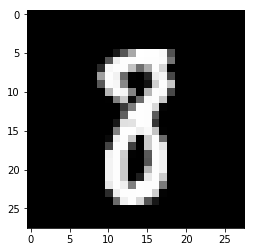

In [8]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [9]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

In [10]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

In [11]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [12]:
# 定义参数
# 真实图像的size
img_size = mnist.train.images[0].shape[0]
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

In [13]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

In [14]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

In [15]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [16]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.0436(Real: 0.0136 + Fake: 0.0300)... Generator Loss: 3.7520
Epoch 2/300... Discriminator Loss: 1.8140(Real: 0.8520 + Fake: 0.9621)... Generator Loss: 1.8342
Epoch 3/300... Discriminator Loss: 1.5945(Real: 0.9054 + Fake: 0.6891)... Generator Loss: 1.1706
Epoch 4/300... Discriminator Loss: 1.5004(Real: 0.7997 + Fake: 0.7007)... Generator Loss: 1.0868
Epoch 5/300... Discriminator Loss: 0.8092(Real: 0.3923 + Fake: 0.4168)... Generator Loss: 1.0281
Epoch 6/300... Discriminator Loss: 1.6308(Real: 1.0720 + Fake: 0.5587)... Generator Loss: 1.3499
Epoch 7/300... Discriminator Loss: 1.7134(Real: 0.9436 + Fake: 0.7698)... Generator Loss: 1.4768
Epoch 8/300... Discriminator Loss: 1.7517(Real: 1.1194 + Fake: 0.6323)... Generator Loss: 0.9498
Epoch 9/300... Discriminator Loss: 1.2959(Real: 0.7911 + Fake: 0.5047)... Generator Loss: 1.2000
Epoch 10/300... Discriminator Loss: 3.0258(Real: 1.2158 + Fake: 1.8100)... Generator Loss: 0.4961
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 0.9003(Real: 0.3982 + Fake: 0.5021)... Generator Loss: 1.2585
Epoch 86/300... Discriminator Loss: 1.1684(Real: 0.7214 + Fake: 0.4470)... Generator Loss: 1.5182
Epoch 87/300... Discriminator Loss: 0.8800(Real: 0.4547 + Fake: 0.4253)... Generator Loss: 1.3563
Epoch 88/300... Discriminator Loss: 0.9784(Real: 0.4758 + Fake: 0.5025)... Generator Loss: 1.2468
Epoch 89/300... Discriminator Loss: 1.0670(Real: 0.5742 + Fake: 0.4928)... Generator Loss: 1.4736
Epoch 90/300... Discriminator Loss: 0.9469(Real: 0.2993 + Fake: 0.6476)... Generator Loss: 1.1328
Epoch 91/300... Discriminator Loss: 0.9352(Real: 0.5582 + Fake: 0.3769)... Generator Loss: 1.6711
Epoch 92/300... Discriminator Loss: 0.7954(Real: 0.3641 + Fake: 0.4313)... Generator Loss: 1.4401
Epoch 93/300... Discriminator Loss: 0.9607(Real: 0.4279 + Fake: 0.5328)... Generator Loss: 1.2400
Epoch 94/300... Discriminator Loss: 1.1168(Real: 0.4736 + Fake: 0.6432)... Generator Loss: 1.1413
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 0.9907(Real: 0.5356 + Fake: 0.4551)... Generator Loss: 1.4139
Epoch 169/300... Discriminator Loss: 0.9591(Real: 0.3431 + Fake: 0.6160)... Generator Loss: 1.1690
Epoch 170/300... Discriminator Loss: 1.0527(Real: 0.5842 + Fake: 0.4685)... Generator Loss: 1.3397
Epoch 171/300... Discriminator Loss: 0.9428(Real: 0.2815 + Fake: 0.6612)... Generator Loss: 1.0869
Epoch 172/300... Discriminator Loss: 1.0777(Real: 0.5230 + Fake: 0.5547)... Generator Loss: 1.3330
Epoch 173/300... Discriminator Loss: 1.1516(Real: 0.4832 + Fake: 0.6684)... Generator Loss: 0.9355
Epoch 174/300... Discriminator Loss: 1.0370(Real: 0.5650 + Fake: 0.4720)... Generator Loss: 1.2935
Epoch 175/300... Discriminator Loss: 1.0362(Real: 0.7375 + Fake: 0.2986)... Generator Loss: 1.8092
Epoch 176/300... Discriminator Loss: 1.0034(Real: 0.5422 + Fake: 0.4612)... Generator Loss: 1.3434
Epoch 177/300... Discriminator Loss: 0.9247(Real: 0.5333 + Fake: 0.3914)... Generator Loss: 1.4044
Epoch 178/

Epoch 251/300... Discriminator Loss: 0.7140(Real: 0.3624 + Fake: 0.3516)... Generator Loss: 1.5959
Epoch 252/300... Discriminator Loss: 1.0058(Real: 0.5768 + Fake: 0.4289)... Generator Loss: 1.4759
Epoch 253/300... Discriminator Loss: 0.7378(Real: 0.4186 + Fake: 0.3192)... Generator Loss: 1.7064
Epoch 254/300... Discriminator Loss: 0.7421(Real: 0.3827 + Fake: 0.3594)... Generator Loss: 1.5932
Epoch 255/300... Discriminator Loss: 0.9103(Real: 0.5324 + Fake: 0.3780)... Generator Loss: 1.6189
Epoch 256/300... Discriminator Loss: 0.9900(Real: 0.4619 + Fake: 0.5280)... Generator Loss: 1.1210
Epoch 257/300... Discriminator Loss: 0.8888(Real: 0.4892 + Fake: 0.3996)... Generator Loss: 1.3568
Epoch 258/300... Discriminator Loss: 1.0291(Real: 0.6174 + Fake: 0.4117)... Generator Loss: 1.6205
Epoch 259/300... Discriminator Loss: 0.9330(Real: 0.4208 + Fake: 0.5122)... Generator Loss: 1.2259
Epoch 260/300... Discriminator Loss: 1.0071(Real: 0.4788 + Fake: 0.5283)... Generator Loss: 1.2921
Epoch 261/

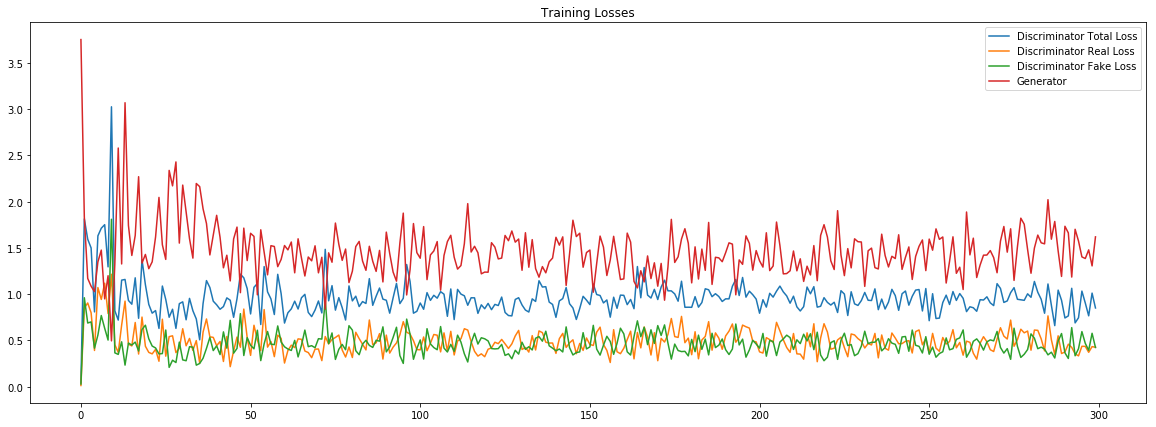

In [17]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

In [18]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [19]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

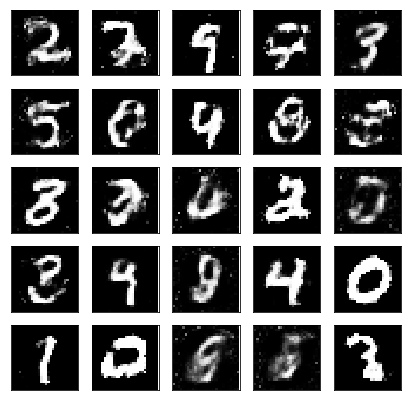

In [20]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

In [21]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

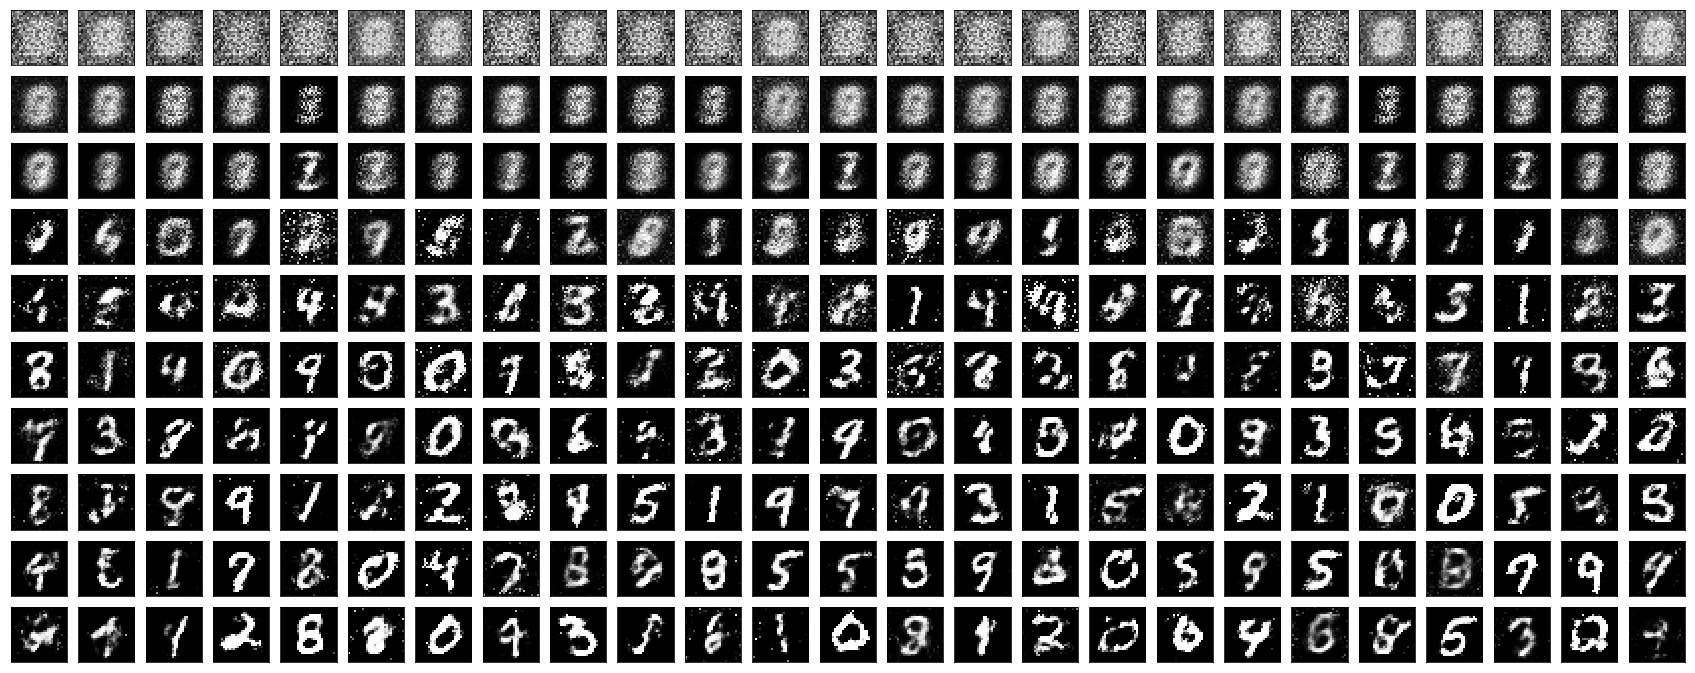

In [22]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [23]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


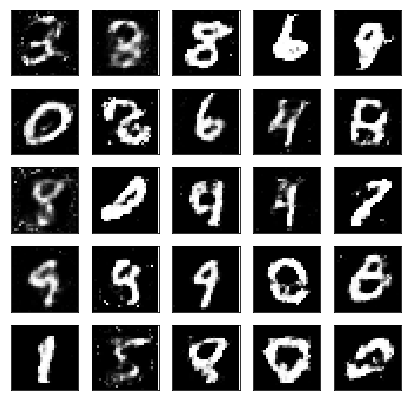

In [24]:
_ = view_samples(0, [gen_samples])